In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Submission & Comments Count Statistics
------

In [4]:
base_dir = '../posts_categorization/linked_submissions_comments'
save_dir = '../posts_categorization/concatenated_linked_datasets'
os.makedirs(save_dir, exist_ok=True)

In [5]:
suicide_dfs = []
depression_dfs = []

for filename in tqdm(os.listdir(base_dir), desc='Processing files'):
    if filename.endswith(".csv"):
        filepath = os.path.join(base_dir, filename)
        if "suicide" in filename:
            suicide_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        elif "depression" in filename:
            depression_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        else:
            print("Error: Non-relevant datasets.")

concatenated_suicide_linked = pd.concat(tqdm(suicide_dfs, desc="Concatenating suicide data"), ignore_index=True)
concatenated_depression_linked = pd.concat(tqdm(depression_dfs, desc="Concatenating depression data"), ignore_index=True)

concatenated_suicide_linked = concatenated_suicide_linked.drop(concatenated_suicide_linked.columns[0], axis=1)
concatenated_depression_linked = concatenated_depression_linked.drop(concatenated_depression_linked.columns[0], axis=1)

linked_suicide_save_path = os.path.join(save_dir, "concatenated_suicide_linked.csv")
linked_depression_save_path = os.path.join(save_dir, "concatenated_depression_linked.csv")

concatenated_suicide_linked.to_csv(linked_suicide_save_path, index=False)
concatenated_depression_linked.to_csv(linked_depression_save_path, index=False)

Processing files:  50%|█████     | 4/8 [00:04<00:05,  1.38s/it]

Error: Non-relevant datasets.


Concatenating depression data: 100%|██████████| 3/3 [00:00<00:00, 63872.65it/s]


In [6]:
def analyze_submission_comment_distribution(dataframe):
    unique_submissions = dataframe[['submitter_username', 'content_submission', 'thread_id']].drop_duplicates()
    total_submissions = unique_submissions.shape[0]

    unique_comments = dataframe[['commenter_username', 'content_comment', 'thread_id']]
    total_comments = unique_comments.shape[0]

    submission_counts = unique_submissions.groupby('thread_id').size().reset_index(name='submission_count')

    comment_counts = unique_comments.groupby('thread_id').size().reset_index(name='comment_count')

    merged_counts = pd.merge(submission_counts, comment_counts, on='thread_id', how='left').fillna(0)

    plt.figure(figsize=(10, 6))
    plt.hist(merged_counts['comment_count'], bins=range(0, merged_counts['comment_count'].max() + 1), edgecolor='black')
    plt.title('Distribution of Comments per Submission')
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Submissions')
    plt.show()

    print(f"Total number of submissions: {total_submissions}")
    print(f"Total number of comments: {total_comments}")

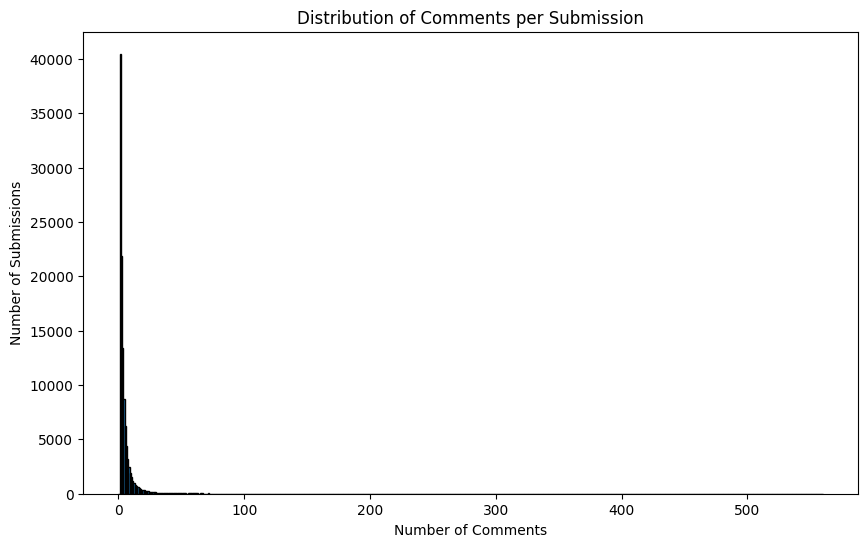

Total number of submissions: 114829
Total number of comments: 570077


In [7]:
analyze_submission_comment_distribution(concatenated_suicide_linked)

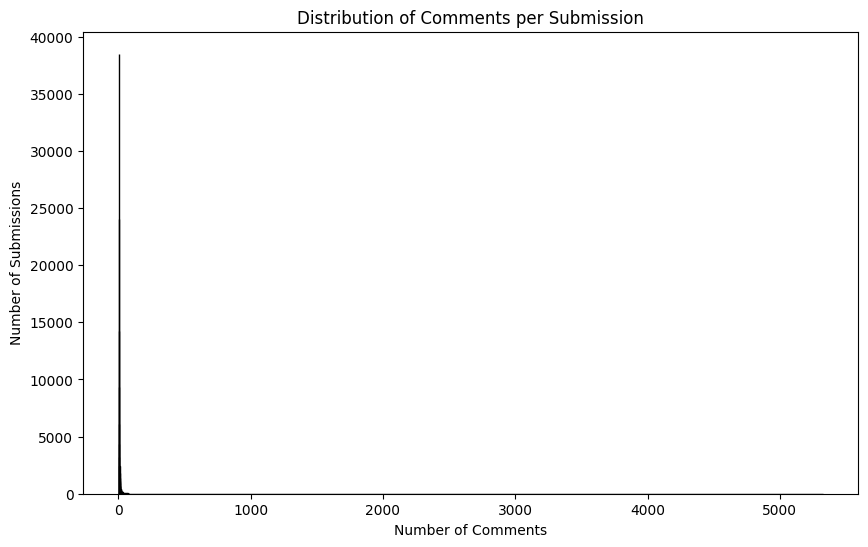

Total number of submissions: 115494
Total number of comments: 622216


In [8]:
analyze_submission_comment_distribution(concatenated_depression_linked)

In [9]:
def generate_category_statistics(year, subreddit_name, type, categ_methods=['llama', 'gemma', 'qwen']):
    if type == 'submissions':
        if year == 2020 or year == 2022 or year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'submissions_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['submissions_category', f'{categ_method}_submissions_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='submissions_category', how='outer')

        categ_stats_merged['mean_submissions_count'] = categ_stats_merged[[f'{categ_method}_submissions_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    elif type == 'comments':
        if year == 2020 or year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'comments_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['comments_category', f'{categ_method}_comments_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='comments_category', how='outer')

        categ_stats_merged['mean_comments_count'] = categ_stats_merged[[f'{categ_method}_comments_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    print(categ_stats_merged)

In [10]:
generate_category_statistics('all', 'suicide', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    83047                   100123   
1                    2                    20686                    12055   
2                    3                     1526                      372   
3                    4                     9570                     2279   

   qwen_submissions_count  mean_submissions_count  
0                   94056                92408.67  
1                   11072                14604.33  
2                    1618                 1172.00  
3                    8083                 6644.00  


In [11]:
generate_category_statistics('all', 'depression', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    80022                    89663   
1                    2                    30822                    24145   
2                    3                     1812                      678   
3                    4                     2838                     1008   

   qwen_submissions_count  mean_submissions_count  
0                   89393                86359.33  
1                   20107                25024.67  
2                    2658                 1716.00  
3                    3336                 2394.00  


In [12]:
generate_category_statistics('all', 'suicide', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                213554                309972   
1                 2                228160                 84033   
2                 3                 55872                 44127   
3                 4                 72491                131945   

   qwen_comments_count  mean_comments_count  
0               235672            253066.00  
1               134869            149020.67  
2                44376             48125.00  
3               155160            119865.33  


In [13]:
generate_category_statistics('all', 'depression', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                230233                323848   
1                 2                243288                 99080   
2                 3                 87129                 85250   
3                 4                 61566                114038   

   qwen_comments_count  mean_comments_count  
0               252618            268899.67  
1               164074            168814.00  
2                75360             82579.67  
3               130164            101922.67  


In [66]:
years = [2020, 2023, 2024, 'all']
subreddit_names = ['suicide', 'depression']
types = ['submissions', 'comments']

for year in years:
    for subreddit_name in subreddit_names:
        for type in types:
            generate_category_statistics('all', 'depression', 'submissions')